In [1]:
import pandas as pd
from pandas.io.json import json_normalize
import json
import csv
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from scipy import optimize

## Create Nutrient Matrix
- This will create a 2D numpy array that we can transpose to use in our linear program optimization

In [2]:
# Import data
foundation_foods_2023 = 'resource/foundationDownload.json'
with open(foundation_foods_2023, 'r') as file:
    data = json.load(file)

In [3]:
# Function to extract the relevant nutrient information from the json file
def extract_info(item):
    # Extract the description
    description = item.get('description', 'No Description Available')

    # Extract food nutrients, assuming it's a list of dictionaries
    nutrients = item.get('foodNutrients', [])

    # Create a simplified structure for nutrients
    simplified_nutrients = []
    for nutrient in nutrients:
        nutrient_info = {
            'Nutrient Name': nutrient.get('nutrient', {}).get('name', 'Unknown'),
            'Amount': nutrient.get('amount', 'Unknown'),
            'Unit': nutrient.get('nutrient', {}).get('unitName', 'Unknown')
        }
        simplified_nutrients.append(nutrient_info)

    return description, simplified_nutrients

In [4]:
food_items = {}
for item in data['FoundationFoods']:
    description, nutrients = extract_info(item)
    nutrientDict = {}
    for nutrient in nutrients:
        if nutrient['Unit'] != 'kJ': # Filters out Energy in kJ
            nutrientDict[nutrient['Nutrient Name']] = nutrient['Amount']
    food_items[description] = nutrientDict

In [5]:

nutrient_matrix = []
nutrient_keys = ['Total lipid (fat)', 'Fatty acids, total monounsaturated', 'Carbohydrate, by difference',
                              'Sodium, Na', 'Fiber, total dietary', 'Protein', 'Sugars, Total', 'Energy']
food_item_indices = {}


# Iterate through each food item in the food_items dictionary
for index, (food_name, nutrients) in enumerate(food_items.items()):
    nutrient_row = [nutrients.get(key, 0) for key in nutrient_keys]  # Use 0 as default value for missing nutrients
    nutrient_matrix.append(nutrient_row)
    
    food_item_indices[food_name] = index # Mapping food descriptions to matrix indices
    
# Convert the list to a NumPy array
nutrient_matrix_np = np.array(nutrient_matrix)

### Returns
- `nutrient_matrix_np` - 2D numpy array that holds the nutrient values (nutrients for 100g of food)
- `food_item_indices` - Dictionary of food item descriptions matched with matrix row index

## Create Map of Food descriptions to emissions
- The csv file has data for both matrix row index and emissions for each food decription
- I want to replace the redundant row index information for a diet tag
    - one for each diet (omnivore, vegetarian, vegan, ...)

In [6]:
file_path_mapped = 'resource/Food_map_emissions.csv'

# Initialize an empty dictionary
food_emissions_dict = {}

food_item_list = []

# Re-open the file to read and create the dictionary
with open(file_path_mapped, mode='r') as file:
    # Create a CSV reader object
    reader = csv.reader(file)
    next(reader)  # Skip the header row if there is one

    # Iterate over the rows in the CSV file
    for row in reader:
        key = row[0]  # Assuming the first column is the key
        value_tuple = (row[1], row[2])  # Assuming the next two columns are the values

        # Add to the dictionary
        food_emissions_dict[key] = float(value_tuple[1])  # Already have a dict mapping to matrix rows. Just need emission values
        
        food_item_list.append(key)

### Returns
- `food_emissions_dict` - Dictionary mapping food descriptions to emission values (in KG of emissions to KG of food)
- `food_item_list` - List of all food item descriptions (Strings)

## Functions
- Input: Food description
- the functions need to be ran in sequence

In [7]:
# Takes a string 
# Returns a numpy array
def get_matrix_row(food_desc):
    row_index = food_item_indices[food_desc]
    if row_index is not None:
        return nutrient_matrix_np[int(row_index)]
    else:
        return None

In [8]:
# Takes a string 
# Returns a float
def get_emissions(food_desc):
    if food_emissions_dict.get(food_desc) == '':
        return None
    return float(food_emissions_dict.get(food_desc))  # kg/kg ratio same as 100g/100g ratio. 

In [9]:
# Takes a string 
# Returns a numpy array and a float (or None)
def get_food_data(food_desc):
    nutrition = get_matrix_row(food_desc)
    emissions = get_emissions(food_desc)
    return nutrition, emissions

In [10]:
# Takes a list of int or None
# Returns a dictionary
def get_daily_rec_intake(rec_intake=None):
    if rec_intake is None:
        rec_intake = [78, 20, 275, 2300, 28, 50, 50, 2000]
        
    index = 0
    daily_rec_intake = {}
    for key in nutrient_keys:
        daily_rec_intake[key] = rec_intake[index]
        index += 1
        
    return daily_rec_intake

In [11]:
# Takes a string 
# Returns a float or None
def get_food_score(food_desc):
    nutrition, emissions = get_food_data(food_desc)
    dri = list(get_daily_rec_intake().values())

    nutrition_score = 0
    for index in range(len(nutrition)):
        nutrition_score += nutrition[index] / dri[index]
    avg = nutrition_score / len(nutrition)
    if emissions is None:
        return None

    food_score = emissions / avg

    return food_score

In [12]:
# Takes a numpy matrix, non numpy array or list, array or list
# Returns sp.optimize.linprog object
def optimal(matrix_np, constraints_list, emissions_list, bounds):
    if bounds is None:
        bounds = (0, None)
    # Constraint matrix upper bound (Also used as lower bound matrix)

    A_ub = matrix_np.T * -1

    # Inequality constraint vector lower bound
    b_lb = np.array(constraints_list)

    # Inequality constraint vector upper bound
    b_ub = b_lb * -1

    # Coefficients of linear objective function (c * food_item_amount = food_item_emissions * food_item_amount)
    c = np.array(emissions_list)  # Somehow I'm gonna need to find the emissions per 100g of each item

    result = sp.optimize.linprog(c, A_ub, b_ub, None, None, bounds, 'simplex')

    return result

In [91]:
def optimal_upper(matrix_np, constraints_list, emissions_list, bounds):
    if bounds is None:
        bounds = (0, None)
    # Constraint matrix upper bound (Also used as lower bound matrix)

    A_ub = matrix_np.T * -1
    
    A_lb = matrix_np.T
    
    A_lb_ub = np.vstack((A_lb, A_ub))

    # Inequality constraint vector lower bound
    b_lb = np.array(constraints_list)

    # Inequality constraint vector upper bound
    b_ub = b_lb * -1
    
    b_lb_ub = np.concatenate((b_lb * 1.5, b_ub))

    # Coefficients of linear objective function (c * food_item_amount = food_item_emissions * food_item_amount)
    c = np.array(emissions_list)  # Somehow I'm gonna need to find the emissions per 100g of each item

    result = sp.optimize.linprog(c, A_lb_ub, b_lb_ub, None, None, bounds, 'simplex')

    return result

In [13]:
# Takes list
# Returns numpy matrix
def create_diet_matrix(food_list):
    matrix = []
    if food_list:
        for item in food_list:
            row, emissions = get_food_data(item)
            matrix.append(row)
            
    return np.array(matrix)

In [14]:
# Takes list
# Returns dictionary
def create_all_food_scores_dict(food_list):
    all_food_scores = {}
    for item in food_list:
        score = get_food_score(item)
        all_food_scores[item] = score
        
    return all_food_scores

In [15]:
def set_bounds(food_dict):
    bounds = []
    for item in food_item_list:
        if item in food_dict.keys():
            bounds.append((food_dict[item][0], food_dict[item][1]))
        else:
            bounds.append((0,None))
    return bounds

In [16]:
def get_first_two_words(text):
    # Split the string into words based on spaces
    words = text.split()

    # Return the first two words joined by a space
    # If there are less than two words, it returns what's available
    return ' '.join(words[:2])

In [17]:
def plot_df(df_sorted, width, height):
    # Plotting
    plt.figure(figsize=(width, height))  # Adjust the figure size as needed for readability
    plt.bar(df_sorted['Category'], df_sorted['Value'], color='skyblue')
    plt.ylabel('Value')
    plt.xlabel('Category')
    plt.xticks(rotation=90)  # Rotate category labels to avoid overlap
    plt.title('Category Values')
    plt.tight_layout()  # Adjust layout to make room for the category labels

    # Show plot
    plt.show()

### How to use functions
- `get_matrix_row`
    - Input: string
    - Output: numpy 1D array
- `get_emissions`
    - Input: string
    - Output: float
- `get_food_data`
    - Input: string
    - Output: numpy array, float or None
- `get_daily_rec_intake`
    - Input: list or None
    - Output: dictionary
- `get_food_score`
    - Input: string
    - Output: float
- `optimal`
    - Input: matrix_np, constraints_list, emissions_list
    - Returns: sp.optimize.linprog object
        - Look at documentation for specifics
- `create_diet_matrix`
    - Input: List of strings
    - Output: numpy 2D array
- `create_all_food_scores_dict`
    - Input: List of strings
    - Output: Dictionary

## Omnivore Diet

In [92]:
constraints_list = [78, 20, 275, 2300, 28, 50, 50, 2000]
emissions_list = []
food_list = []
scores_list = []

for key, value in food_emissions_dict.items():
    emissions_list.append(value)
    scores_list.append(get_food_score(key))
    food_list.append(key)

matrix_np = create_diet_matrix(food_list)
    
omni_optimal = optimal_upper(matrix_np, constraints_list, emissions_list, None)

print('-------------------Scores--------------------------')
scores_optimal = optimal_upper(matrix_np, constraints_list, scores_list, None)
print(scores_optimal)
optimal_scores = {}
scores_sum = 0
for j in range(len(food_list)):
    if scores_optimal.x[j] >= 0.001:
        optimal_scores[food_list[j]] = scores_optimal.x[j]
        print(food_list[j], scores_optimal.x[j], get_food_score(food_list[j]), get_emissions(food_list[j]))
        scores_sum += get_emissions(food_list[j]) * scores_optimal.x[j]
print(scores_sum)

print('--------------------End Scores-------------------------')
print(omni_optimal)
omni_foods_sum = 0
optimal_foods = {}
for i in range(len(food_list)):
    if omni_optimal.x[i] >= 0.001:
        optimal_foods[food_list[i]] = omni_optimal.x[i]
        print(food_list[i], omni_optimal.x[i], get_emissions(food_list[i]))
        omni_foods_sum += get_food_score(food_list[i]) * omni_optimal.x[i]
print(omni_foods_sum)

print('---------------------------------------------')

optimal_foods_scores = []
for item in optimal_foods.keys():
    score = get_food_score(item)
    optimal_foods_scores.append(score)
    print(item, score)

print(sum(optimal_foods_scores))
print('---------------------------------------------')

omni_total_scores_dict = create_all_food_scores_dict(list(optimal_foods.keys()))

df = pd.DataFrame(list(omni_total_scores_dict.items()), columns=['Category', 'Value'])

df_sorted = df.sort_values(by='Value', ascending=True)
df_sorted['Category'] = df_sorted['Category'].apply(lambda x: get_first_two_words(x))

print(df_sorted)

-------------------Scores--------------------------
     con: array([], dtype=float64)
     fun: 31.45616664939114
 message: 'Optimization terminated successfully.'
     nit: 39
   slack: array([ 0.00000000e+00, -3.55271368e-15,  1.37500000e+02,  1.15000000e+03,
        3.17338719e-01,  1.77725884e+01, -1.42108547e-14,  1.00000000e+03,
        3.90000000e+01,  1.00000000e+01,  0.00000000e+00, -4.54747351e-13,
        1.36826613e+01,  7.22741158e+00,  2.50000000e+01,  0.00000000e+00])
  status: 0
 success: True
       x: array([0.        , 0.        , 0.        , 0.        , 0.57074262,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.66057026,
       0.        , 0.        , 0.        , 0.5165175 , 0.        ,
     

In [19]:
bounds_dict = {}
bounds_dict['Beef, round, top round, boneless, choice, raw'] = (1, None)
bounds_dict['Nuts, almonds, dry roasted, with salt added'] = (0, 0)
bounds_dict['Olives, green, Manzanilla, stuffed with pimiento'] = (0, 0)
bounds_dict['Figs, dried, uncooked'] = (0, 0)
bounds_dict['Flour, potato'] = (0, 0)

bounds = set_bounds(bounds_dict)
beef_optimal = optimal(matrix_np, constraints_list, emissions_list, bounds)
print(beef_optimal)

beef_optimal_foods = {}
for i in range(len(food_list)):
    if beef_optimal.x[i] >= 0.001:
        beef_optimal_foods[food_list[i]] = beef_optimal.x[i]
        print(food_list[i], beef_optimal.x[i])
        
print('---------------------------------------------')

beef_foods_scores = []
for item in beef_optimal_foods.keys():
    score = get_food_score(item)
    beef_foods_scores.append(score)
    print(item, score)

    
print('---------------------------------------------')

print(sum(beef_foods_scores))

     con: array([], dtype=float64)
     fun: 105.28456973954235
 message: 'Optimization terminated successfully.'
     nit: 32
   slack: array([ 1.13906631e+02,  3.84201584e+01,  5.68434189e-14, -1.36424205e-12,
       -1.42108547e-14,  4.13398285e+01,  2.13162821e-14, -9.09494702e-13])
  status: 0
 success: True
       x: array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 4.31240875, 0.        , 0.17645909, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.99025886,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
     

In [20]:
# Pizza
pizza_list = {}
pizza_list['Flour, wheat, all-purpose, enriched, bleached'] = 2.5
pizza_list['Oil, olive, extra virgin'] = .3
pizza_list['Sugars, granulated'] = .02
pizza_list['Cheese, mozzarella, low moisture, part-skim'] = 1.25
pizza_list['Tomatoes, canned, red, ripe, diced'] = 2
pizza_list['Mushrooms, shiitake'] = 1
pizza_list['Sausage, Italian, pork, mild, cooked, pan-fried'] = 2

pizza_scores = []
pizza_emissions = []
for key, value in pizza_list.items():
    print(key, get_food_score(key), get_emissions(key))
    pizza_scores.append(get_food_score(key))
    pizza_emissions.append(get_emissions(key) * value)

print("emissions: ", sum(pizza_emissions))
print("Total Score: ", sum(pizza_scores))

Flour, wheat, all-purpose, enriched, bleached 17.89339893742282 1.57
Oil, olive, extra virgin 11.976878612716762 5.18
Sugars, granulated 10.018710078464531 3.2
Cheese, mozzarella, low moisture, part-skim 129.668359633873 23.88
Tomatoes, canned, red, ripe, diced 105.53502834631321 2.09
Mushrooms, shiitake 81.82999059275106 2.35
Sausage, Italian, pork, mild, cooked, pan-fried 54.38002449574854 12.31
emissions:  66.543
Total Score:  411.3023906972899


In [95]:
print('---------------------------------------------')

total_scores_dict = create_all_food_scores_dict(food_item_list)

df = pd.DataFrame(list(total_scores_dict.items()), columns=['Category', 'Value'])

df_sorted = df.sort_values(by='Value', ascending=True)

# df_sorted['Category'] = df_sorted['Category'].apply(lambda x: get_first_two_words(x))

print(df_sorted)

print(df_sorted.dtypes)

print(df_sorted.describe())

---------------------------------------------
                                              Category        Value
4          Nuts, almonds, dry roasted, with salt added     0.901587
148                              Almond butter, creamy     0.958480
157                          Nuts, pecans, halves, raw     1.024752
155                          Nuts, almonds, whole, raw     1.106618
156                Nuts, walnuts, English, halves, raw     1.817896
..                                                 ...          ...
44   Beef, short loin, porterhouse steak, separable...  1123.431851
150                              Lettuce, iceberg, raw  1125.465957
43   Beef, round, top round roast, boneless, separa...  1254.060602
42   Beef, round, eye of round roast, boneless, sep...  1263.069681
213      Beef, round, top round, boneless, choice, raw  1302.610610

[223 rows x 2 columns]
Category     object
Value       float64
dtype: object
             Value
count   223.000000
mean    134.165049
std

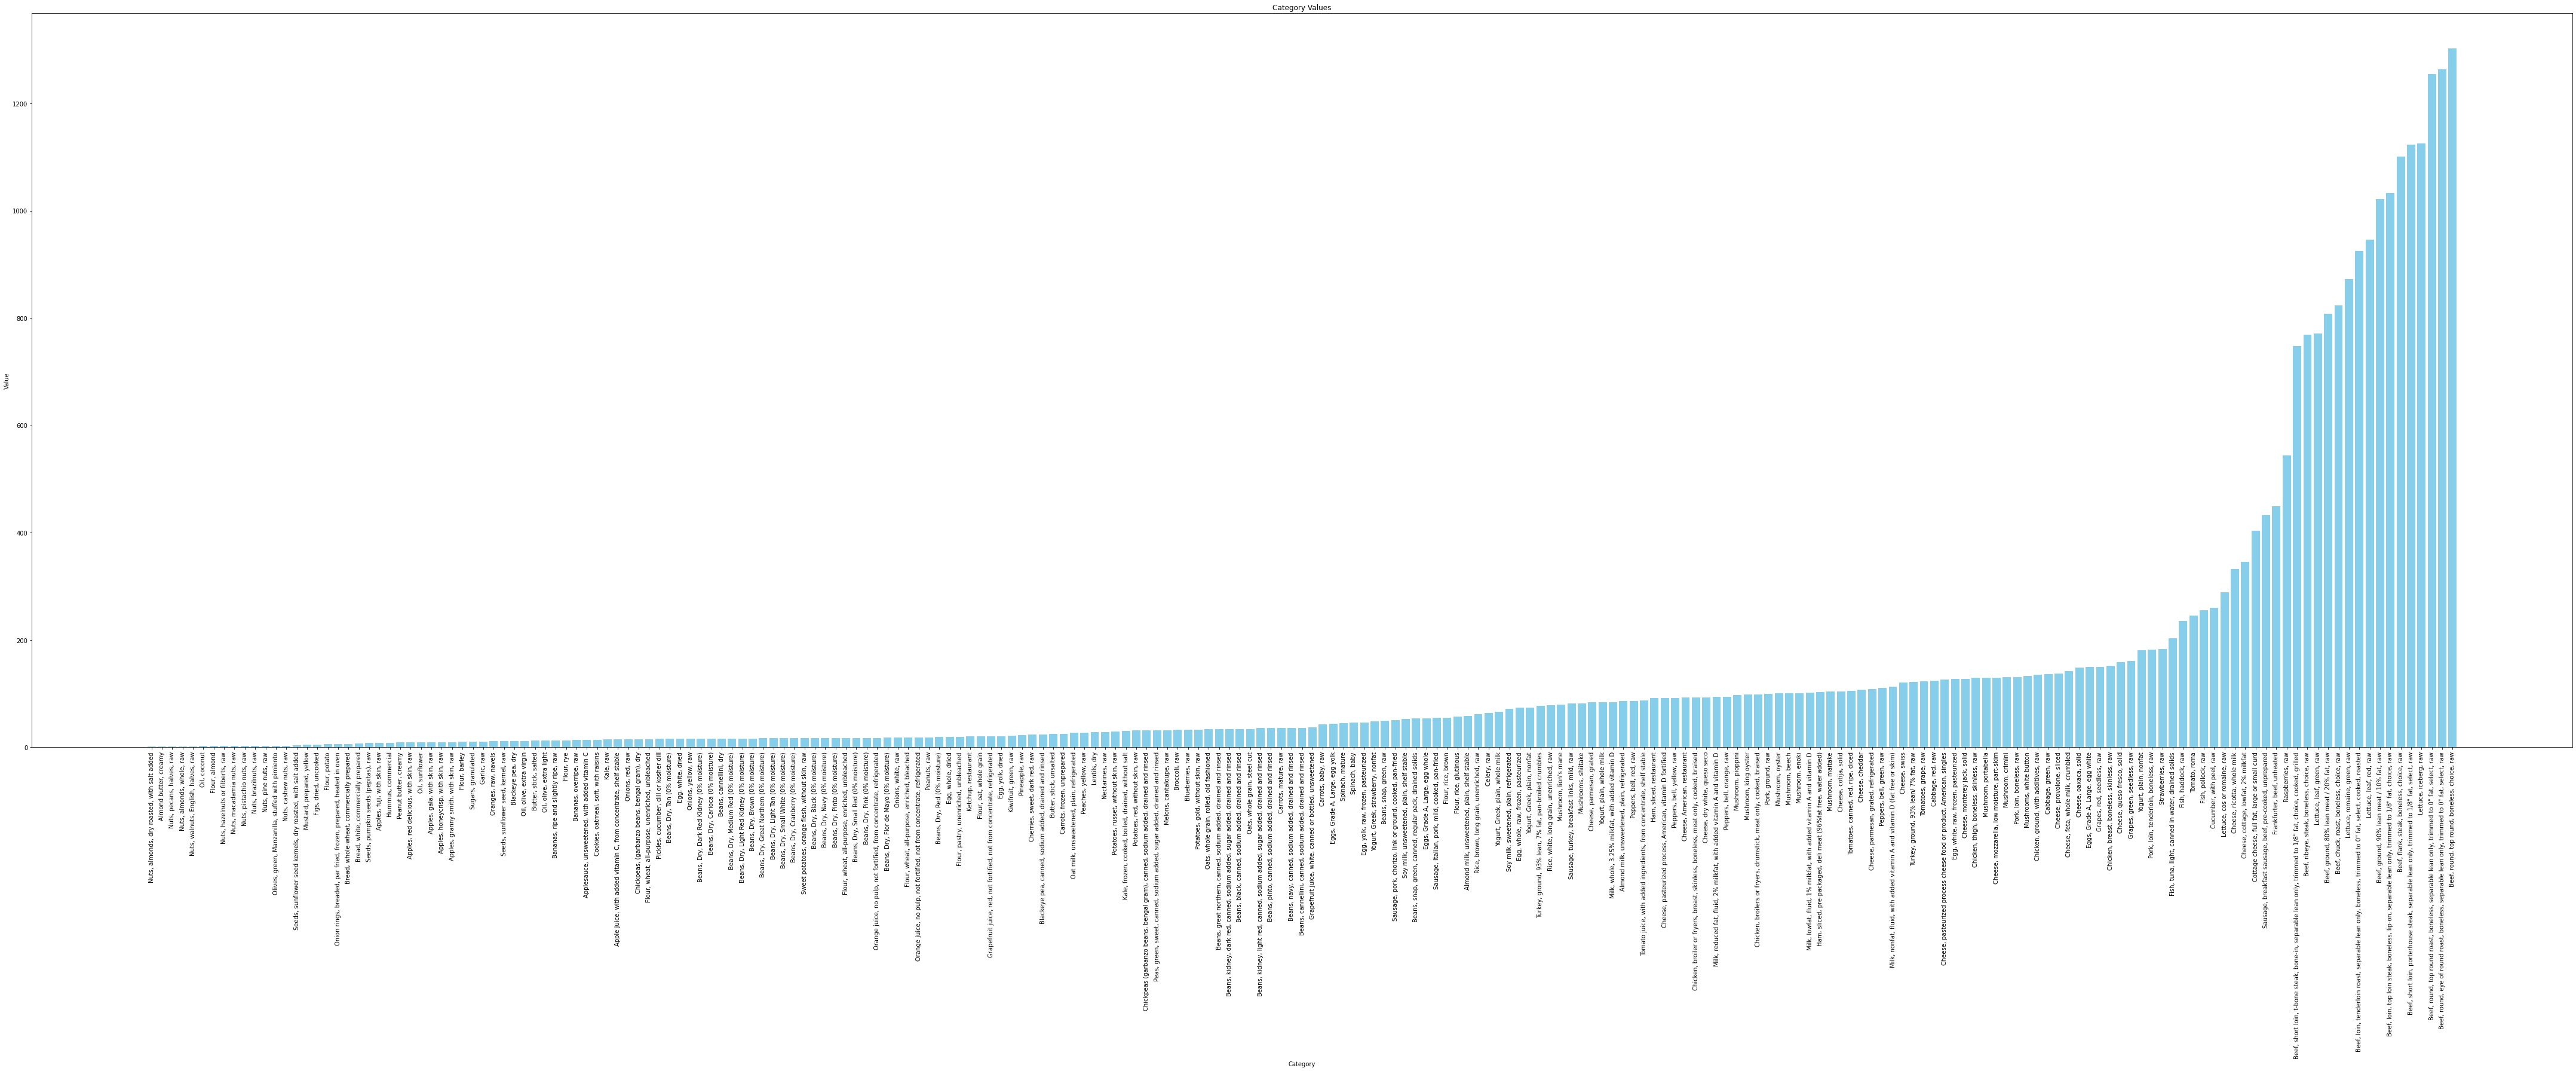

In [22]:
plot_df(df_sorted, 60, 25)

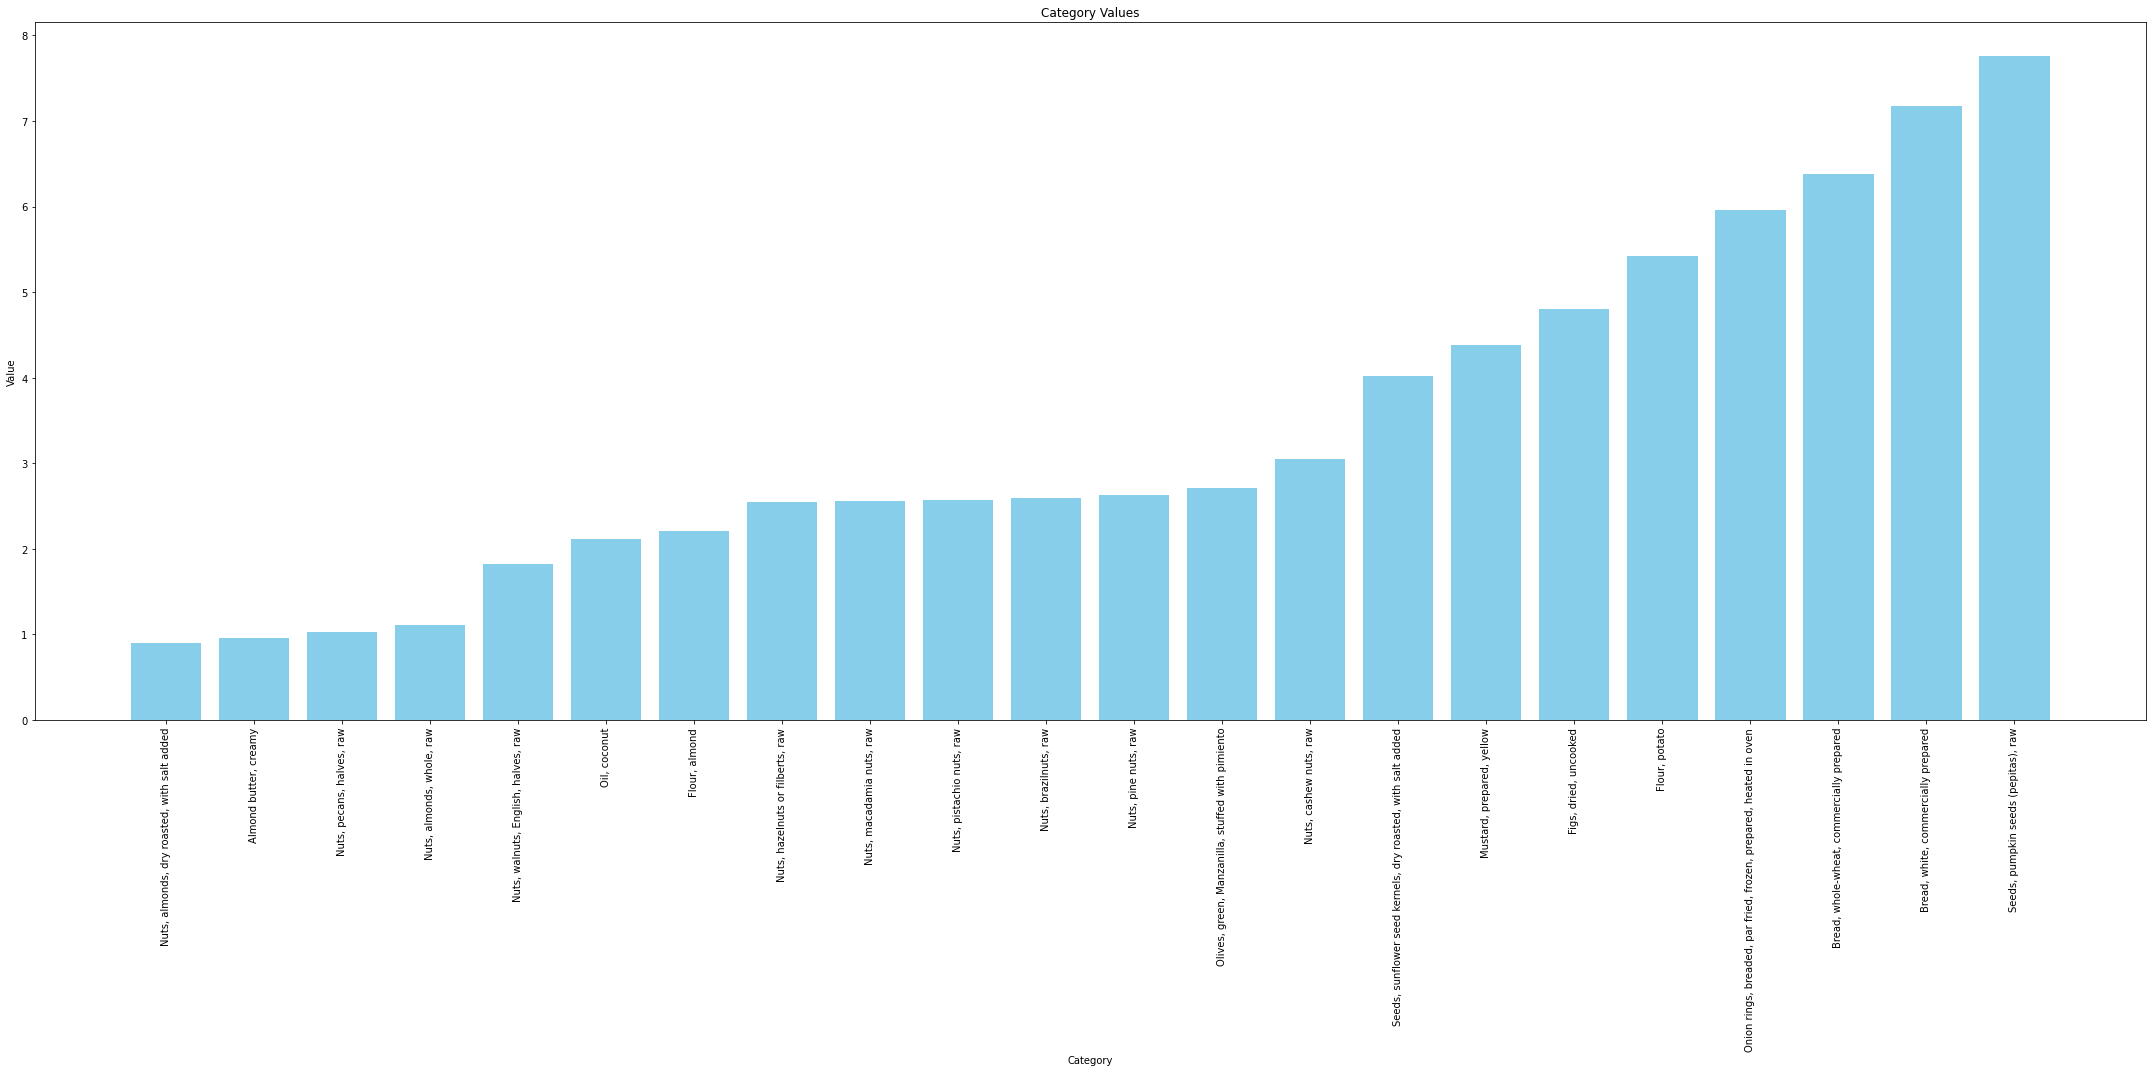

In [96]:
# Calculate the number of rows to include the top 25%
top_25_percent_rows = int(len(df_sorted) * 0.10)

# Select the top 25% of rows
df_top_25_percent = df_sorted.head(top_25_percent_rows)

plot_df(df_top_25_percent, 30, 15)

In [24]:
print(get_food_score('Lettuce, iceberg, raw'))
print(get_emissions('Lettuce, iceberg, raw'))

1125.4659574977584
4.93


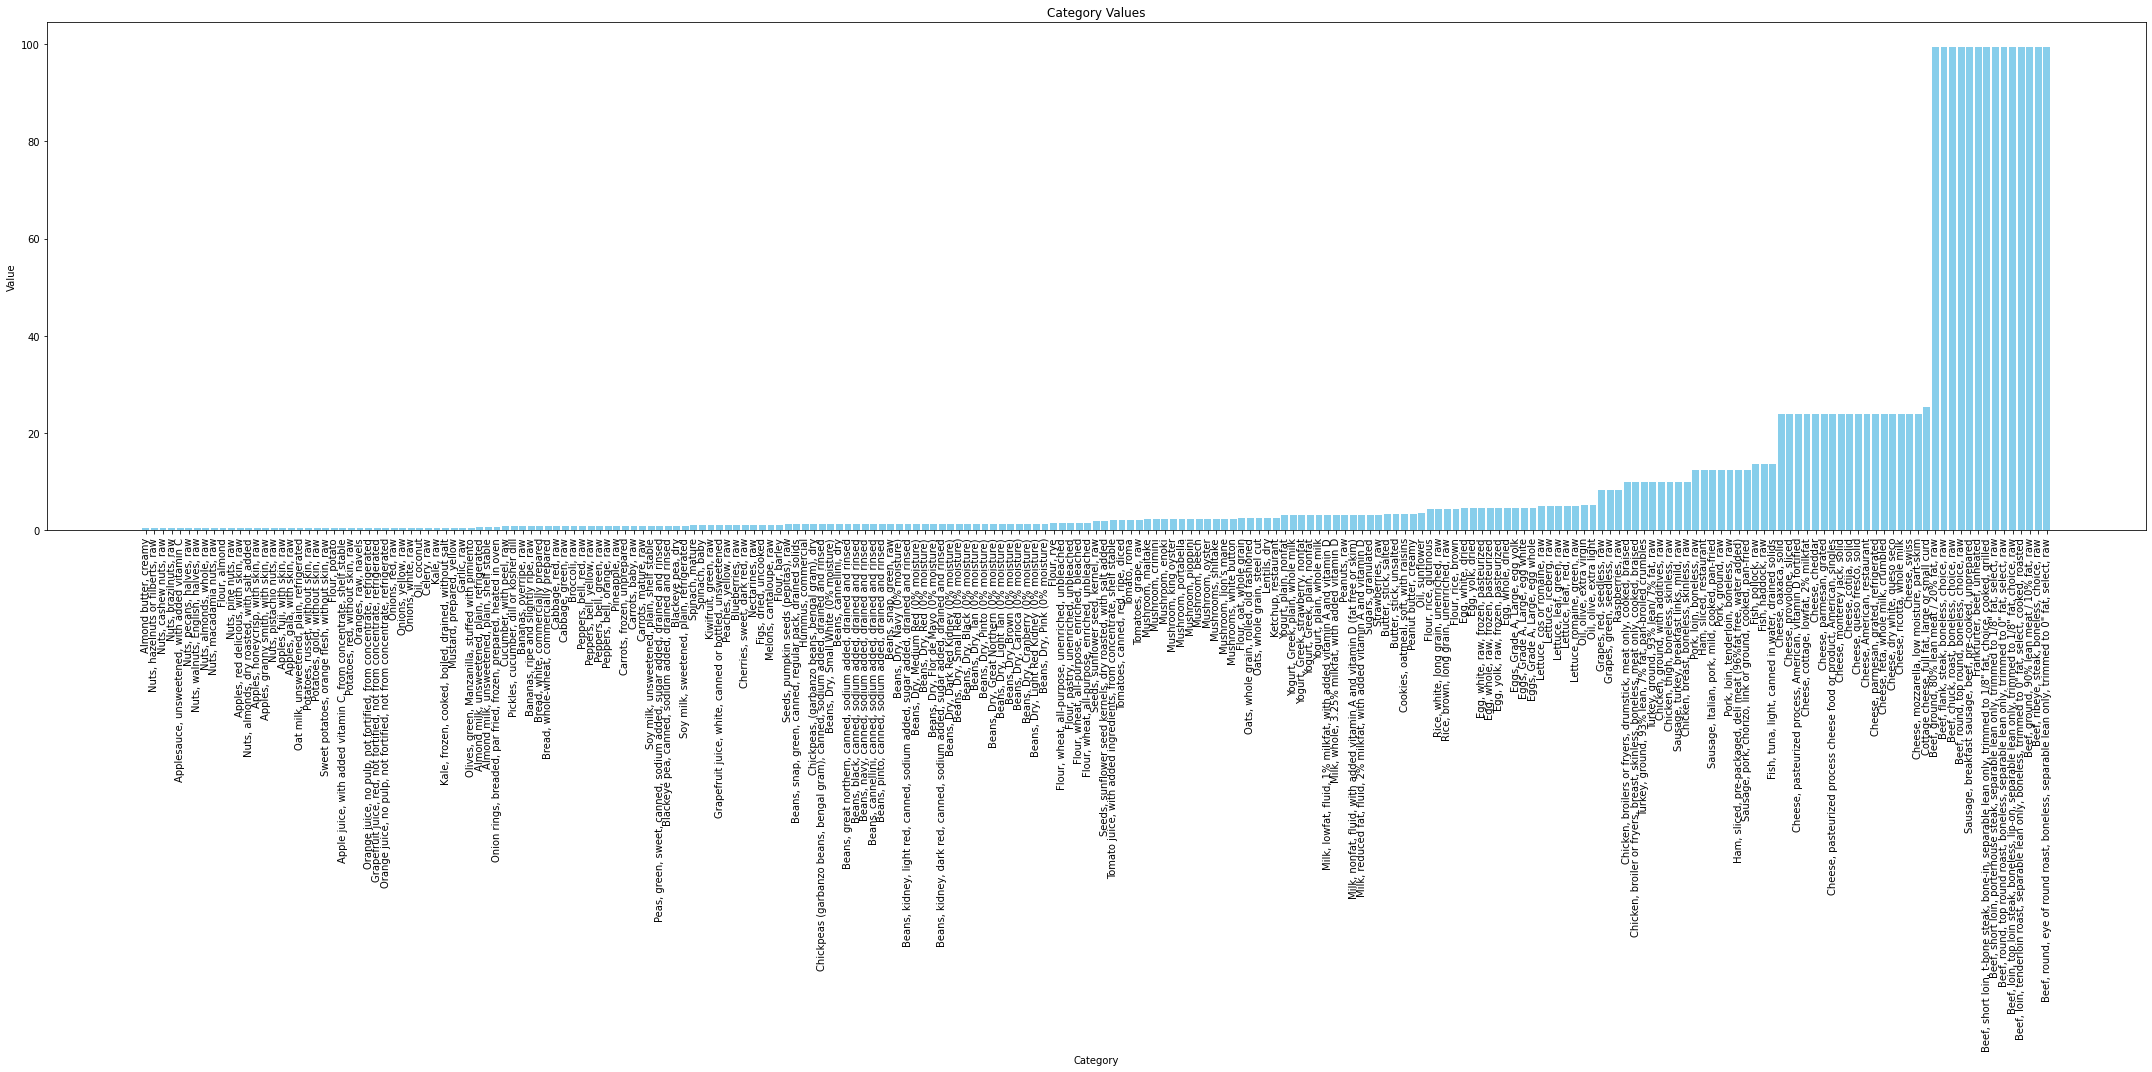

            Value
count  223.000000
mean    10.571031
std     23.957763
min      0.390000
25%      0.935000
50%      1.930000
75%      4.930000
max     99.480000
                                              Category  Value
148                              Almond butter, creamy   0.39
188                   Nuts, hazelnuts or filberts, raw   0.43
187                             Nuts, cashew nuts, raw   0.43
186                              Nuts, brazilnuts, raw   0.43
176      Applesauce, unsweetened, with added vitamin C   0.43
..                                                 ...    ...
41   Beef, loin, top loin steak, boneless, lip-on, ...  99.48
40   Beef, loin, tenderloin roast, separable lean o...  99.48
181         Beef, ground, 90% lean meat / 10% fat, raw  99.48
212         Beef, ribeye, steak, boneless, choice, raw  99.48
42   Beef, round, eye of round roast, boneless, sep...  99.48

[223 rows x 2 columns]


In [54]:
df_emissions = pd.DataFrame(list(food_emissions_dict.items()), columns=['Category', 'Value'])
df_emissions_sorted = df_emissions.sort_values(by='Value', ascending=True)
plot_df(df_emissions_sorted, 30, 15)
print(df_emissions_sorted.describe())
print(df_emissions_sorted)

In [ ]:
df_joined = df.compare(df_emissions)
df_joined_sorted = df_joined.sort_values(by=('Value', 'self'), ascending=True)
print(df_joined_sorted)

diff_dict = {}
for item in food_item_list:
    diff = abs(get_food_score(item) - get_emissions(item))
    diff_dict[item] = diff
df_diff = pd.DataFrame(list(diff_dict.items()), columns=['Category', 'Value'])
df_diff_sorted = df_diff.sort_values(by='Value', ascending=True)
plot_df(df_diff_sorted, 30, 15)

df_diff_log = df_diff_sorted.copy()
df_diff_log['Value'] = np.log(df_diff['Value'] + 1e-5)
plot_df(df_diff_log, 30, 15)

                                              Category  Value
0                                Almond butter, creamy     -1
1                     Nuts, hazelnuts or filberts, raw     -6
2                               Nuts, cashew nuts, raw    -11
3                                Nuts, brazilnuts, raw     -7
4        Applesauce, unsweetened, with added vitamin C    -38
..                                                 ...    ...
218  Beef, loin, top loin steak, boneless, lip-on, ...      2
219  Beef, loin, tenderloin roast, separable lean o...      6
220         Beef, ground, 90% lean meat / 10% fat, raw      5
221         Beef, ribeye, steak, boneless, choice, raw     13
222  Beef, round, eye of round roast, boneless, sep...      1

[223 rows x 2 columns]


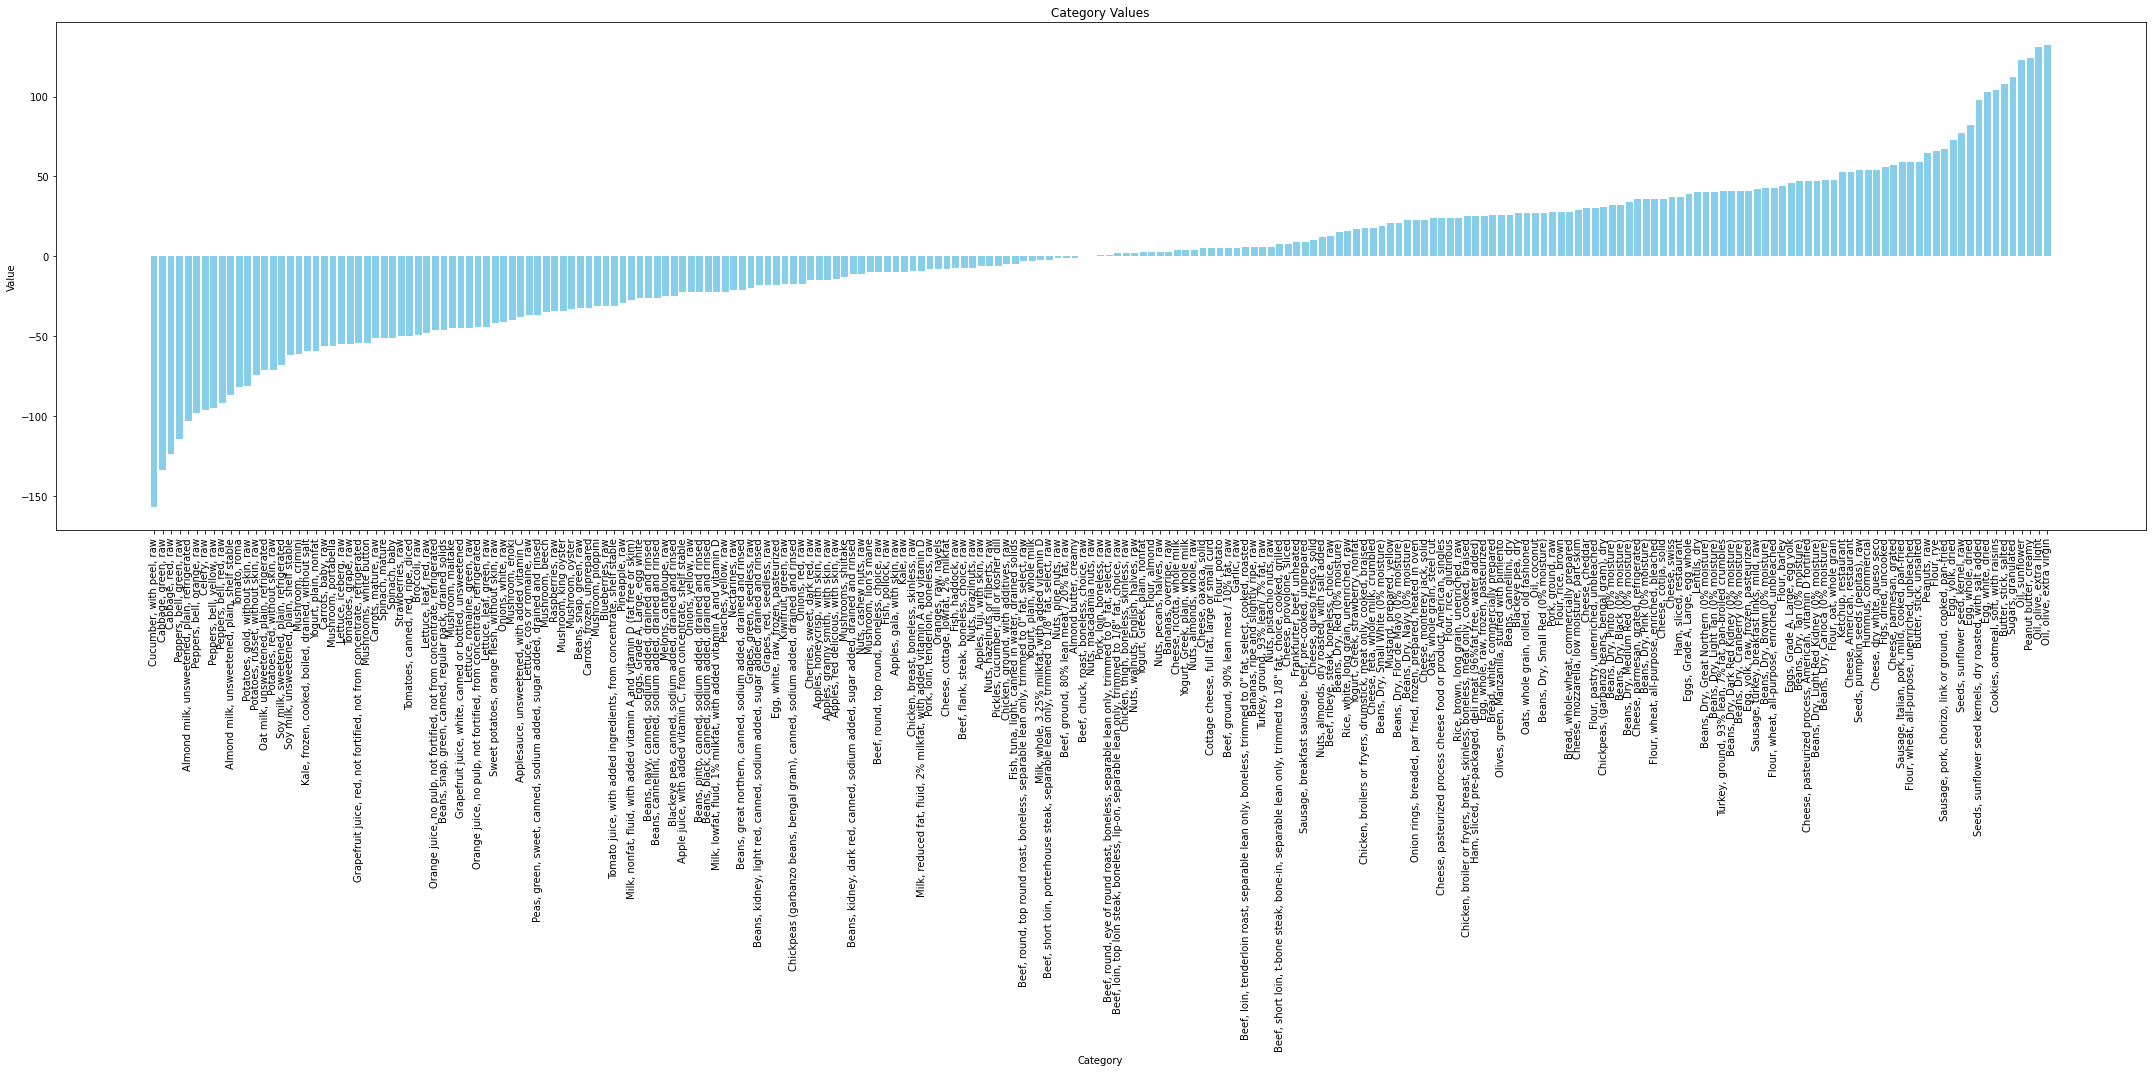

            Value
count  223.000000
mean     0.000000
std     47.614916
min   -157.000000
25%    -28.000000
50%      1.000000
75%     28.500000
max    132.000000


In [56]:
positions_df1 = {label: position for position, label in enumerate(df_emissions_sorted['Category'])}
positions_df2 = {label: position for position, label in enumerate(df_sorted['Category'])}

position_differences = {label: positions_df1[label] - positions_df2[label] for label in positions_df1}

# Convert position_differences to a DataFrame
position_differences_df = pd.DataFrame(list(position_differences.items()), columns=['Category', 'Value'])

print(position_differences_df)
plot_df(position_differences_df.sort_values(by='Value', ascending=True), 30, 15)
print(position_differences_df.describe())

In [53]:
print(get_emissions('Cucumber, with peel, raw'))
print(get_food_score('Cucumber, with peel, raw'))
print(get_emissions('Oil, olive, extra virgin'))
print(get_food_score('Oil, olive, extra virgin'))

0.85
259.837588920821
5.18
11.976878612716762


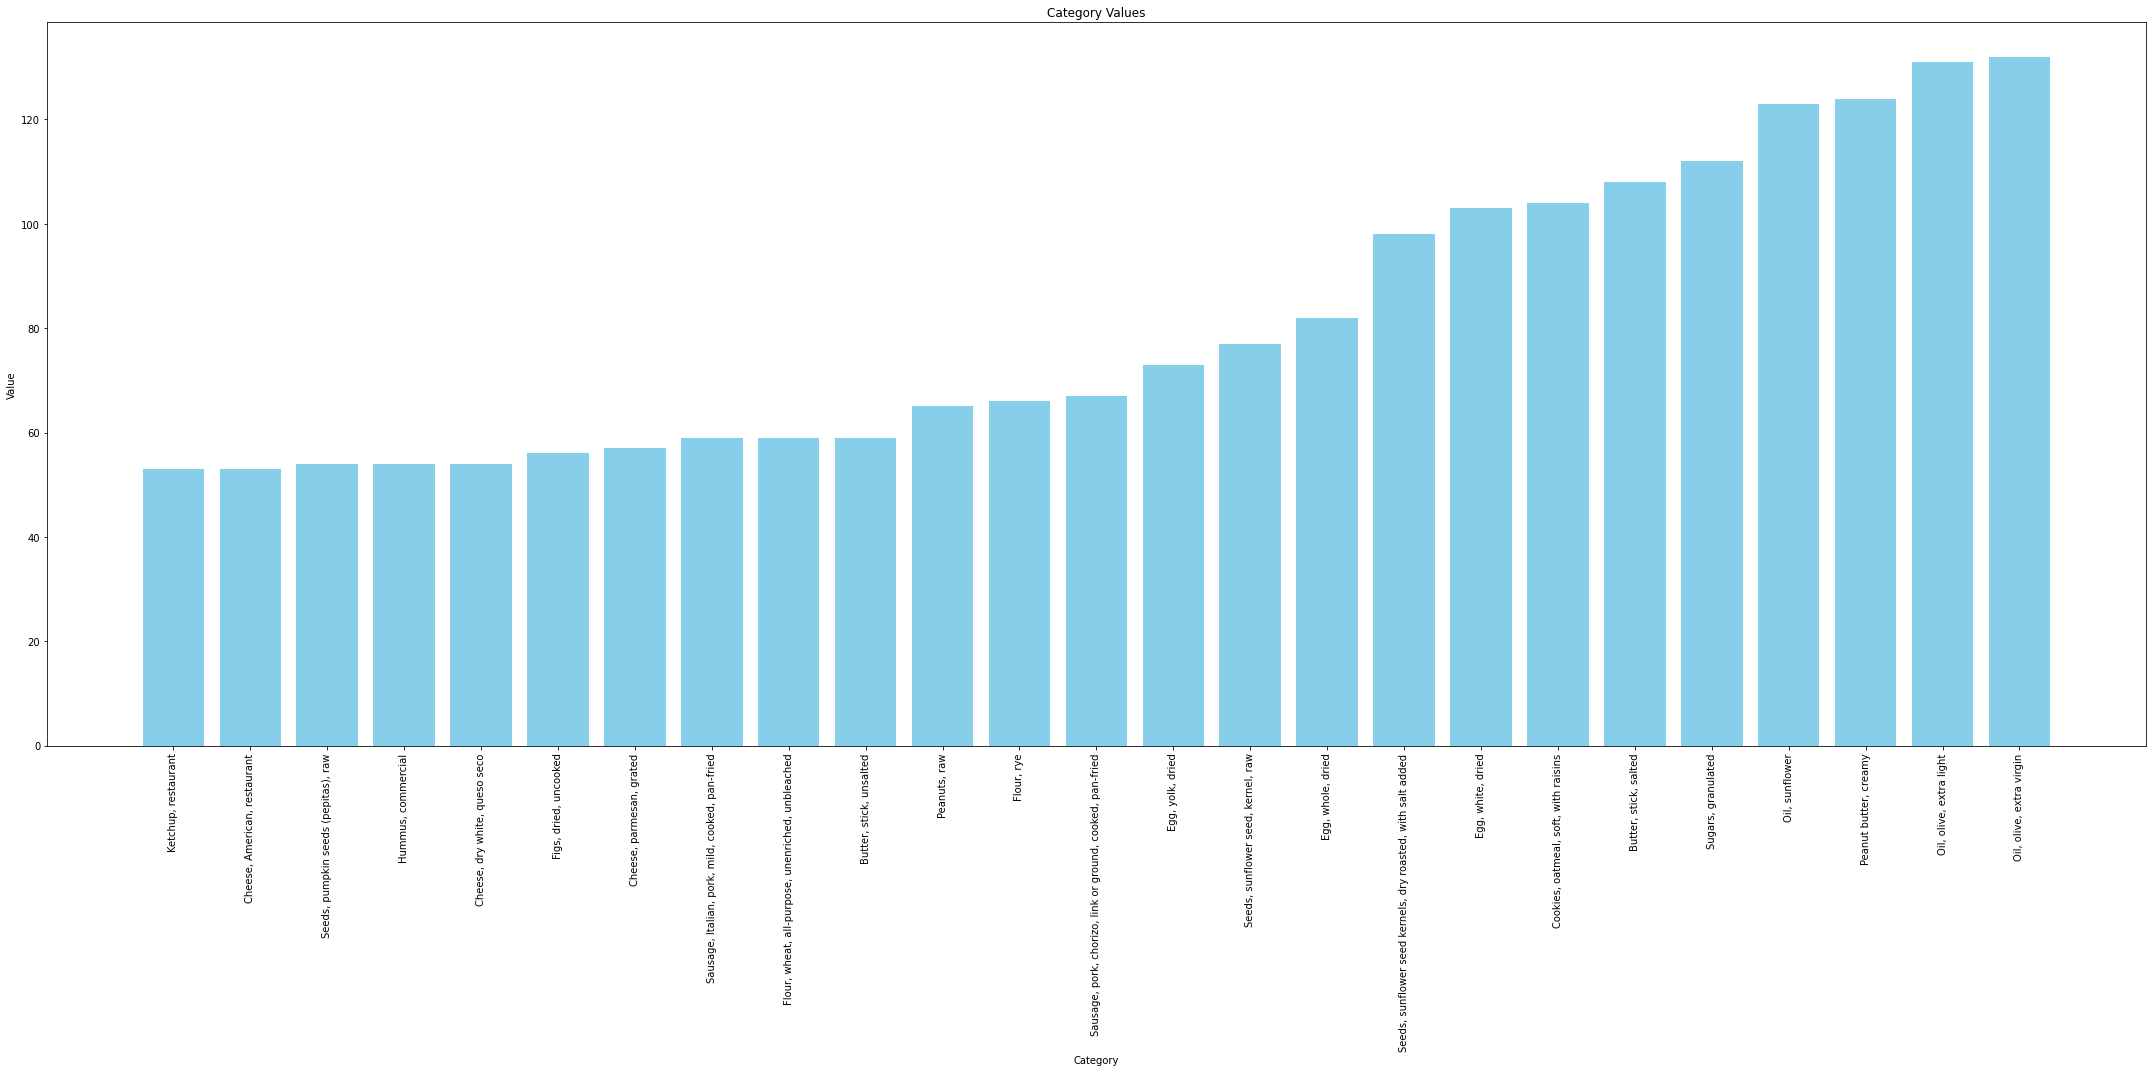

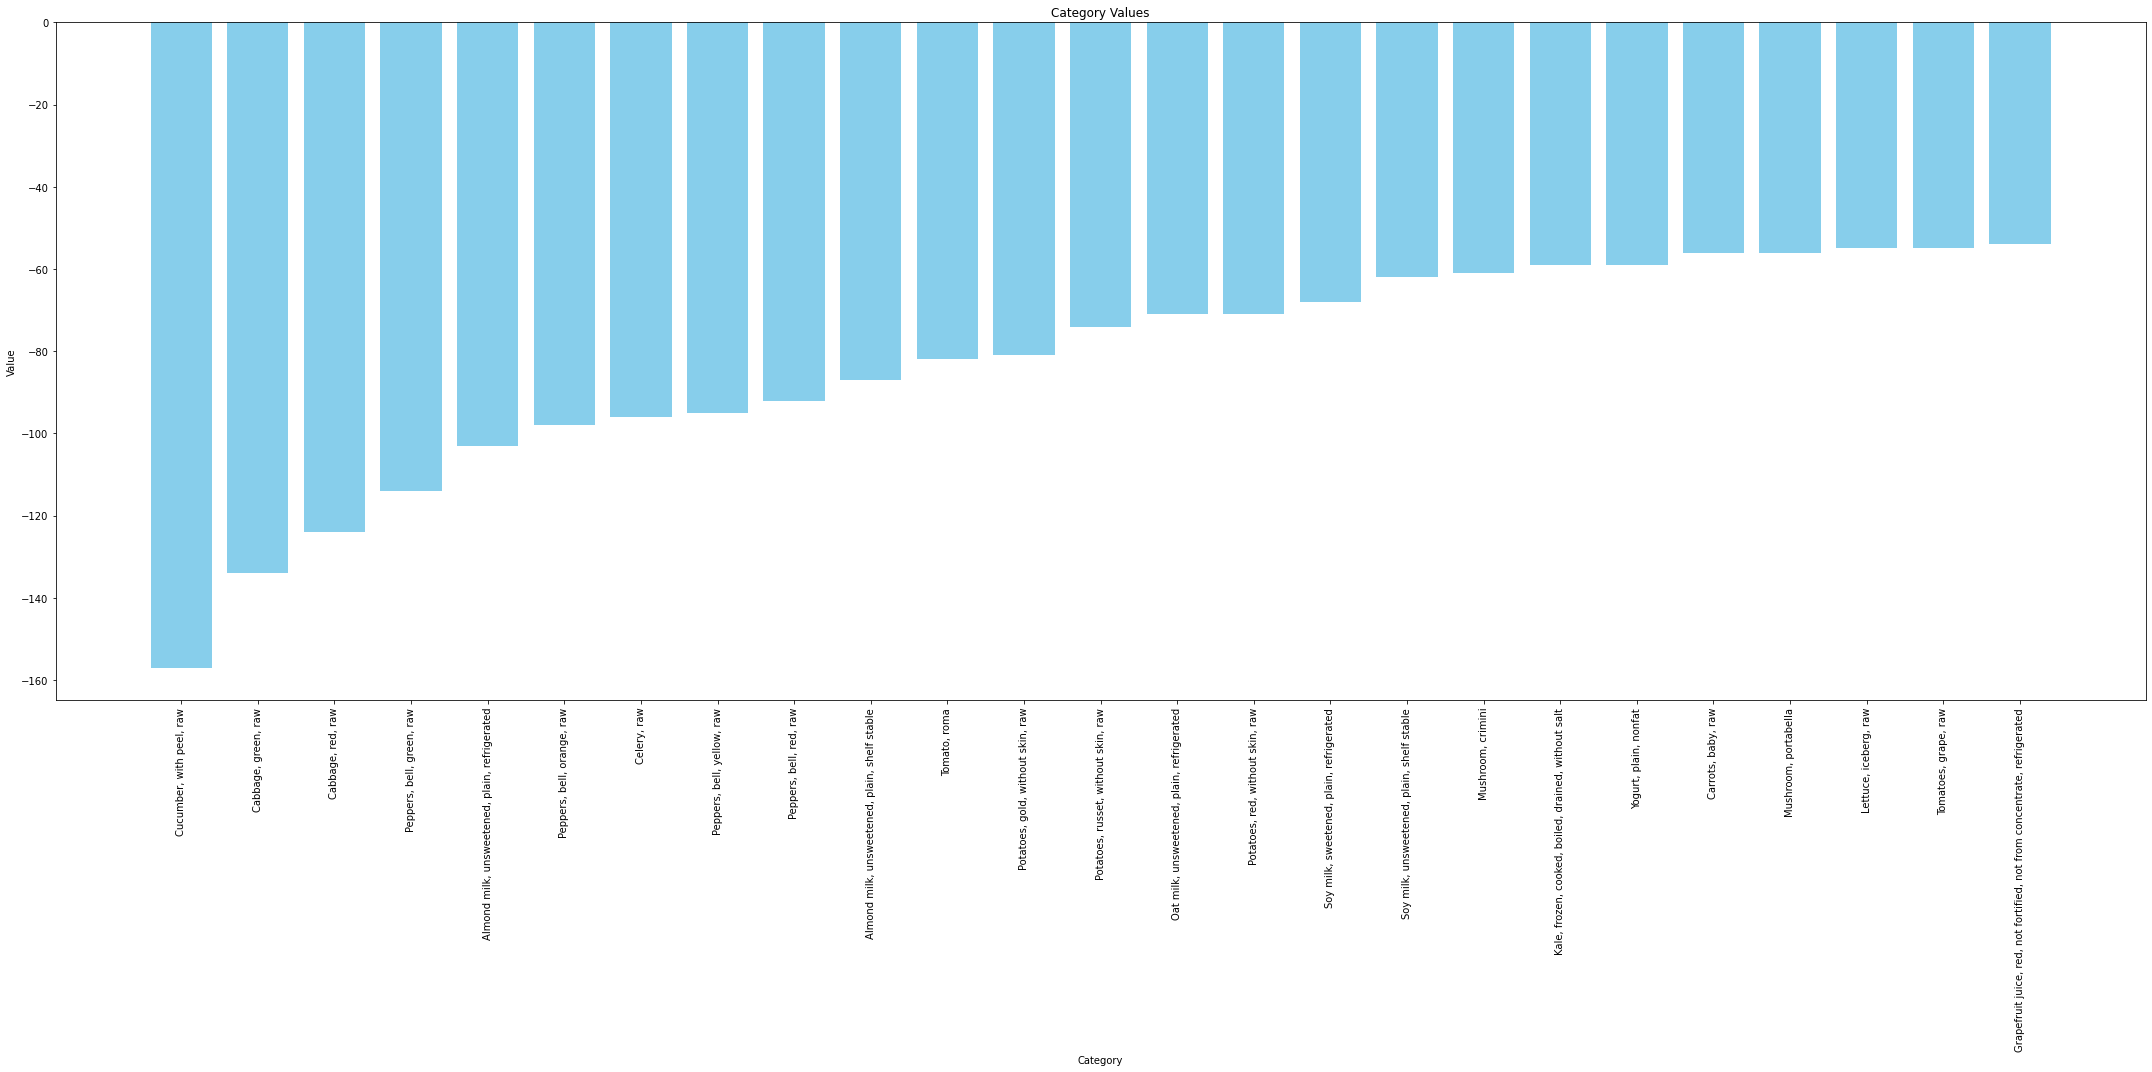

In [55]:
plot_df(position_differences_df.sort_values(by='Value', ascending=True).tail(25), 30, 15)
plot_df(position_differences_df.sort_values(by='Value', ascending=True).head(25), 30, 15)

In [93]:
filtered_df_pos = position_differences_df[abs(position_differences_df['Value']) > 100]
fil_df_pos_sort = filtered_df_pos.sort_values(by='Value', ascending=True)
fil_df_pos_sort['Category'] = fil_df_pos_sort['Category'].apply(get_first_two_words)
print(fil_df_pos_sort)

               Category  Value
42       Cucumber, with   -157
49      Cabbage, green,   -134
48        Cabbage, red,   -124
53       Peppers, bell,   -114
39         Almond milk,   -103
154         Egg, white,    103
147   Cookies, oatmeal,    104
145      Butter, stick,    108
143  Sugars, granulated    112
149      Oil, sunflower    123
148      Peanut butter,    124
169         Oil, olive,    131
168         Oil, olive,    132


In [98]:
print(get_emissions('Cucumber, with peel, raw'))
print(get_food_score('Cucumber, with peel, raw'))
print(get_emissions('Pickles, cucumber, dill or kosher dill'))
print(get_food_score('Pickles, cucumber, dill or kosher dill'))

0.85
259.837588920821
0.85
15.420626465732765


In [78]:
print(get_emissions('Chickpeas, (garbanzo beans, bengal gram), dry'))
print(get_food_score('Chickpeas, (garbanzo beans, bengal gram), dry'))

1.34
14.688183625124479
